In [1]:
# Covid-19 Cases Prediction
# This the full implementation of the RNN to train the model and predict Covid cases and deaths in each state.
# How we accomplished this:
# 1. Download raw data from NY Times Covid-19 datasets on github
# 2. Sort the raw data by state and put each states data in separate files
# 3. Select the state data to predict on and retrieve the data
# 4. Separate out cases data and deaths data and pick one to train/predict on
# 5. Create Recurrent Neural Network
#   5.1. Setup RNNs weights, layers/neurons, learning rate, epoch, gradient clipping
#   5.2. Define heuristic for the RNN - sigmoid
# 6. Training the model
#   6.1. Verify loss on training data -> Forward propagation -> Calculate Error
#   6.2. Verify loss on validation data -> Forward propagation -> Calculate Error
#   6.3. Forward Propagation -> Backward propagation error -> Updated Weights
#   6.4. Repeat for number of epochs 
#
# IMPORTANT: epoch determines how well the model is trained, and different for each state. 
# We only found optimal for Michigan is 16 for cases and 24 for deaths
#
# 7. Run Prediction on training data
# 8. Run Prediction on validation data
# 9. Determine how well model predicts the last 50 days worth of data

In [2]:
# Imports
import requests
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

from sklearn.preprocessing import MinMaxScaler

# Global settings
### change this to either 'cases' or 'deaths' to predict that data
predict_class = "cases"
### change this to whatever state you want, make sure to capitalize first letters
predict_state = "Michigan"

In [3]:
# Get the data - Uncomment to get latest data
rawdata_filepath = "./data/raw-us-states.csv"
data_URL = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
r = requests.get(data_URL)

f = open(rawdata_filepath, 'w')
f.write(str(r.content, 'utf-8'))

522277

In [4]:
# Split raw data by state - Uncomment to split the latest data
with open(rawdata_filepath, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    first_line = next(csv_reader)
    state_filepaths = []

    for line in csv_reader:
        state_filepath = "./data/" + line[1] + ".csv"

        if state_filepath in state_filepaths:
            with open(state_filepath, 'a+', newline='') as append_file:
                # Open file in append mode to add following lines to file
                csv_writer = csv.writer(append_file)
                csv_writer.writerow(line)
        else:
            state_filepaths.append(state_filepath)
            with open(state_filepath, 'w') as write_file:
                # Open file write mode and add column names to file
                csv_writer = csv.writer(write_file)
                csv_writer.writerow(first_line)

In [5]:
# Read the dataset
df = pd.read_csv(f"./data/{predict_state}.csv")
print(df.shape)
df.head()

(274, 5)


,date,state,fips,cases,deaths
0,2020-03-11,Michigan,26,2,0
1,2020-03-12,Michigan,26,12,0
2,2020-03-13,Michigan,26,25,0
3,2020-03-14,Michigan,26,33,0
4,2020-03-15,Michigan,26,53,0


In [6]:
# Display Covid-19 cases to date
df['date'] = pd.to_datetime(df.date, format="%Y-%m-%d")
df.index = df['date']

# plt.plot(df[predict_class], label=f"raw data ({predict_class})")
# plt.legend()

In [7]:
# Separate dataset by class
cases_dataset = np.array([df['cases'][i] for i in np.arange(len(df))])
deaths_dataset = np.array([df['deaths'][i] for i in np.arange(len(df))])

# Choose which data set to predict on
if predict_class is "cases":
    dataset = cases_dataset.reshape(-1, 1)
else:
    dataset = deaths_dataset.reshape(-1, 1)

# dataset.shape

In [8]:
# Normalize: Need to scale data down to train model properly
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Plot scaled dataset to verify its still correct
# plt.plot(scaled_data[:len(scaled_data)], label=f"scaled data ({predict_class})")
# plt.legend()
# scaled_data.shape

In [9]:
# Training to Validation Variables
input_seq = 50     # input days to predict
total_train_len = len(scaled_data) - input_seq
train_len = total_train_len - input_seq
valid_len = total_train_len - train_len
# print(f"Total data: {len(scaled_data)}, Total train: {total_train_len}, Train: {train_len}, Valid: {valid_len}")

In [10]:
# Create training data
x_train = []
y_train = []

for i in range(train_len):
    x_train.append(scaled_data[i:(i + input_seq)])
    y_train.append(scaled_data[i + input_seq])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

# x_train.shape, y_train.shape

In [11]:
# plt.plot(x_train[:, 0], 'g', label=f"training x: first {train_len} days")
# plt.plot(y_train[:, 0], 'b', label=f"training y: shifted left by {input_seq} days")
# plt.legend()

In [12]:
# Create validation data
x_valid = []
y_valid = []

for i in range(train_len, total_train_len):
    x_valid.append(scaled_data[i:(i + input_seq)])
    y_valid.append(scaled_data[i + input_seq])
    
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

# x_valid.shape, y_valid.shape

In [13]:
# plt.plot(x_valid[:, 0], 'g', label=f"validation x: starts at day {train_len}")
# plt.plot(y_valid[:, 0], 'b', label=f"validation y: starts at day {total_train_len}")
# plt.legend()

In [14]:
# Recurrent Neural Network Variables
if predict_class is "cases":
    nepoch = 16                  # Choose number of epoch for cases data 
else:
    nepoch = 24                  # Choose number of epoch for deaths data 

learning_rate = 0.0001

input_neurons = input_seq
hidden_neurons = 100
output_neuron = 1

# Backpropagation through time
bptt = 5

# Gradient clipping
min_gradient = -10
max_gradient = 10

In [15]:
# Recurrent Neural Network Weights
ih_weight = np.random.uniform(0, 1, (hidden_neurons, input_neurons))
hh_weight = np.random.uniform(0, 1, (hidden_neurons, hidden_neurons))
ho_weight = np.random.uniform(0, 1, (output_neuron, hidden_neurons))


In [16]:
# Activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [17]:
# Training the model
for epoch in range(nepoch):
    """ Compute training loss """
    train_loss = 0.0

    # Forward propagation
    for i in range(y_train.shape[0]):
        x_out = x_train[i]
        y_out = y_train[i]

        prev_activation = np.zeros((hidden_neurons, 1))

        for neuron in range(input_neurons):
            new_input = np.zeros(x_out.shape)
            new_input[neuron] = x_out[neuron]
            ih_dot = np.dot(ih_weight, new_input)
            hh_dot = np.dot(hh_weight, prev_activation)
            add = ih_dot + hh_dot
            curr_activation = sigmoid(add)
            ho_dot = np.dot(ho_weight, curr_activation)
            prev_activation = curr_activation

        # Calculate loss
        loss = (y_out - ho_dot)**2 / 2
        train_loss += loss

    train_loss = train_loss / float(y_out.shape[0])

    """ Compute validation loss """
    valid_loss = 0.0

    # Forward propagation
    for i in range(y_valid.shape[0]):
        x_out = x_valid[i]
        y_out = y_valid[i]

        prev_activation = np.zeros((hidden_neurons, 1))

        for neuron in range(input_neurons):
            new_input = np.zeros(x_out.shape)
            new_input[neuron] = x_out[neuron]
            ih_dot = np.dot(ih_weight, new_input)
            hh_dot = np.dot(hh_weight, prev_activation)
            add = ih_dot + hh_dot
            curr_activation = sigmoid(add)
            ho_dot = np.dot(ho_weight, curr_activation)
            prev_activation = curr_activation

        # Calculate loss
        loss = (y_out - ho_dot)**2 / 2
        valid_loss += loss

    valid_loss = valid_loss / float(y_out.shape[0])
    
    print(f"Epoch: {epoch}; Train Loss: {train_loss}; Valid Loss: {valid_loss}")

    """ Train the model """
    for i in range(y_train.shape[0]):
        x_out = x_train[i]
        y_out = y_train[i]
    
        layers = []
        prev_activation = np.zeros((hidden_neurons, 1))
        
        d_ih = np.zeros(ih_weight.shape)
        d_ho = np.zeros(ho_weight.shape)
        d_hh = np.zeros(hh_weight.shape)
        
        dt_ih = np.zeros(ih_weight.shape)
        dt_ho = np.zeros(ho_weight.shape)
        dt_hh = np.zeros(hh_weight.shape)
        
        di_ih = np.zeros(ih_weight.shape)
        di_hh = np.zeros(hh_weight.shape)

        # Forward propagation
        for neuron in range(input_neurons):
            new_input = np.zeros(x_out.shape)
            new_input[neuron] = x_out[neuron]
            ih_dot = np.dot(ih_weight, new_input)
            hh_dot = np.dot(hh_weight, prev_activation)
            add = ih_dot + hh_dot
            curr_activation = sigmoid(add)
            ho_dot = np.dot(ho_weight, curr_activation)
            layers.append({'curr_activation':curr_activation, 'prev_activation':prev_activation})
            prev_activation = curr_activation
        
        # Derivative of prediction
        d_ho_dot = (ho_dot - y_out)

        # Backward propagation
        for neuron in range(input_neurons):
            dt_ho = np.dot(d_ho_dot, np.transpose(layers[neuron]['curr_activation']))
            ds_ho = np.dot(np.transpose(ho_weight), d_ho_dot)
            ds = ds_ho
            dadd = add * (1 - add) * ds
            d_hh_dot = dadd * np.ones_like(hh_dot)

            dprev_activation = np.dot(np.transpose(hh_weight), d_hh_dot)

            for i in range((neuron - 1), max(-1, (neuron - bptt - 1)), -1):
                ds = ds_ho + dprev_activation
                dadd = add * (1 - add) * ds
                d_hh_dot = dadd * np.ones_like(hh_dot)
                d_ih_dot = dadd * np.ones_like(ih_dot)
                di_hh = np.dot(hh_weight, layers[neuron]['prev_activation'])
                dprev_activation = np.dot(np.transpose(hh_weight), d_hh_dot)
                new_input = np.zeros(x_out.shape)
                new_input[neuron] = x_out[neuron]
                di_ih = np.dot(ih_weight, new_input)
                dx = np.dot(np.transpose(ih_weight), d_ih_dot)

                dt_ih += di_ih
                dt_hh += di_hh

            d_ho += dt_ho
            d_ih += dt_ih
            d_hh += dt_hh
            
            if d_ih.max() > max_gradient:
                d_ih[d_ih > max_gradient] = max_gradient
            if d_ho.max() > max_gradient:
                d_ho[d_ho > max_gradient] = max_gradient
            if d_hh.max() > max_gradient:
                d_hh[d_hh > max_gradient] = max_gradient
                
            if d_ih.min() < min_gradient:
                d_ih[d_ih < min_gradient] = min_gradient
            if d_ho.min() < min_gradient:
                d_ho[d_ho < min_gradient] = min_gradient
            if d_hh.min() < min_gradient:
                d_hh[d_hh < min_gradient] = min_gradient
        
        # Update weights
        ih_weight -= learning_rate * d_ih
        ho_weight -= learning_rate * d_ho
        hh_weight -= learning_rate * d_hh


Epoch: 0; Train Loss: [[265469.98842093]]; Valid Loss: [[75080.31879486]]
Epoch: 1; Train Loss: [[124567.78470133]]; Valid Loss: [[34972.26130765]]
Epoch: 2; Train Loss: [[36337.85062424]]; Valid Loss: [[9999.71689965]]
Epoch: 3; Train Loss: [[266.90648234]]; Valid Loss: [[48.30067369]]
Epoch: 4; Train Loss: [[0.88895131]]; Valid Loss: [[2.77645044]]
Epoch: 5; Train Loss: [[4.24303186]]; Valid Loss: [[1.32222952]]
Epoch: 6; Train Loss: [[0.39792915]]; Valid Loss: [[3.63994276]]
Epoch: 7; Train Loss: [[2.02391791]]; Valid Loss: [[2.04200501]]
Epoch: 8; Train Loss: [[1.50805351]]; Valid Loss: [[2.34083491]]
Epoch: 9; Train Loss: [[2.17406642]]; Valid Loss: [[1.97026071]]
Epoch: 10; Train Loss: [[0.61848172]]; Valid Loss: [[3.11562412]]
Epoch: 11; Train Loss: [[1.16719517]]; Valid Loss: [[2.51667933]]
Epoch: 12; Train Loss: [[1.89733557]]; Valid Loss: [[2.09880729]]
Epoch: 13; Train Loss: [[2.61906689]]; Valid Loss: [[1.78791413]]
Epoch: 14; Train Loss: [[1.41146436]]; Valid Loss: [[2.361

In [18]:
# Prediction on training data
train_preds = []

for i in range(y_train.shape[0]):
    x_out = x_train[i]
    y_out = y_train[i]
    
    prev_activation = np.zeros((hidden_neurons, 1))

    # Forward propagation
    for neuron in range(input_neurons):
        ih_dot = np.dot(ih_weight, x_out)
        hh_dot = np.dot(hh_weight, prev_activation)
        add = ih_dot + hh_dot
        curr_activation = sigmoid(add)
        ho_dot = np.dot(ho_weight, curr_activation)
        prev_activation = curr_activation

    train_preds.append(ho_dot)
    
train_preds = np.array(train_preds)

# plt.plot(train_preds[:, 0, 0], 'r', label="prediction on training y data")
# plt.plot(x_train[:, 0], 'g', label="training x")
# plt.plot(y_train[:, 0], 'b', label="training y")
# plt.legend()

In [19]:
# Prediction on validation data
valid_preds = []

for i in range(y_valid.shape[0]):
    x_out = x_valid[i]
    y_out = y_valid[i]

    prev_activation = np.zeros((hidden_neurons, 1))

    # Forward Propagation
    for neuron in range(input_neurons):
        ih_dot = np.dot(ih_weight, x_out)
        hh_dot = np.dot(hh_weight, prev_activation)
        add = ih_dot + hh_dot
        curr_activation = sigmoid(add)
        ho_dot = np.dot(ho_weight, curr_activation)
        prev_activation = curr_activation

    valid_preds.append(ho_dot)
valid_preds = np.array(valid_preds)

# plt.plot(valid_preds[:, 0, 0], 'r', label="prediction on validation y data")
# plt.plot(x_valid[:, 0], 'g', label="validation x")
# plt.plot(y_valid[:, 0], 'b', label="validation y")
# plt.legend()

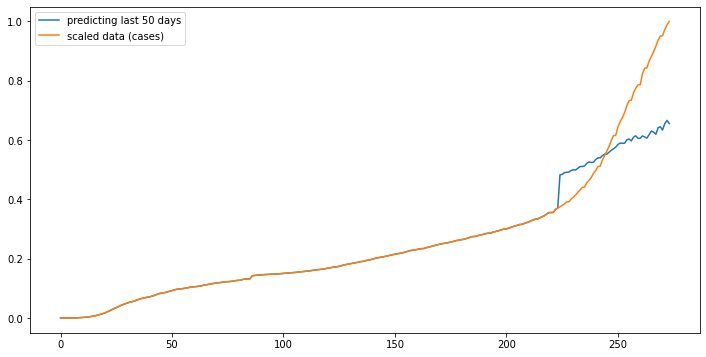

In [20]:
# All plots combined
x_data = np.concatenate((x_train, x_valid), axis=0)
y_data = np.concatenate((y_train, y_valid), axis=0)
# plt.plot(x_data[:, 0], 'g', label="x data - first 80% of scaled data")
# plt.plot(y_data[:, 0], 'b', label="y data - last 80% of scaled data")

init_section = scaled_data[:(len(scaled_data) - valid_len),:, None]
predict = np.concatenate((init_section, valid_preds), axis=0)

plt.plot(predict[:, 0, 0], label=f"predicting last {input_seq} days")
plt.plot(scaled_data[:len(scaled_data)], label=f"scaled data ({predict_class})")
plt.legend()

In [21]:
# Format prediction result and as csv file
prediction_filepath = f"./predictions/{predict_state}_{predict_class}.csv"

predict_df = pd.DataFrame(index=range(0, len(df)), columns=['date', 'state', f'{predict_class}'])

predict = predict.transpose(2,0,1).reshape(predict.shape[0], -1)
predict = scaler.inverse_transform(predict)

for i in range(0, len(df)):
    predict_df['date'][i] = df['date'][i]
    predict_df['state'][i] = df['state'][i]
    predict_df[f'{predict_class}'][i] = predict[i][0]

predict_df['date'] = pd.to_datetime(predict_df.date, format="%Y-%m-%d")
predict_df.to_csv(prediction_filepath, index=False)
# predict_df.tail()

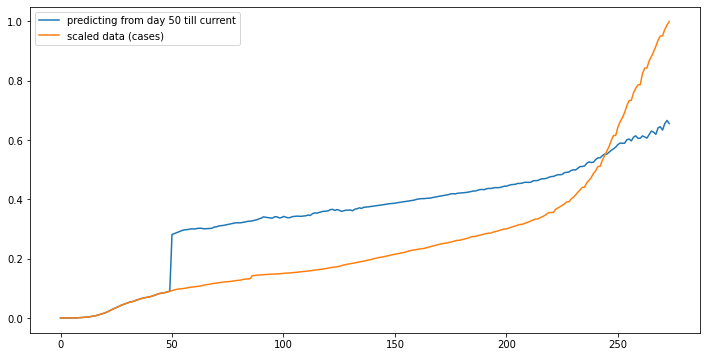

In [22]:
init_section = scaled_data[:input_seq,:, None]
predict = np.concatenate((init_section, train_preds, valid_preds), axis=0)

plt.plot(predict[:, 0, 0], label=f"predicting from day {input_seq} till current")
plt.plot(scaled_data[:len(scaled_data)], label=f"scaled data ({predict_class})")
plt.legend()

In [23]:
# print(f"Scaled data shape: {scaled_data.shape}")
# print(f"Initial section shape: {init_section.shape}")
# print(f"Train predictions shape: {train_preds.shape}, Valid predictions shape: {valid_preds.shape}")
# print(f"Predicted data shape: {predict.shape}")

# print(f"x train shape: {x_train.shape}, x valid shape: {x_valid.shape}")
# print(f"x data shape: {x_data.shape}")

# print(f"y train shape: {y_train.shape}, y valid shape: {y_valid.shape}")
# print(f"y data shape: {y_data.shape}")